In [21]:
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from scipy import signal
from scipy.signal import find_peaks
import copy
from scipy.signal import butter, filtfilt

In [22]:
#read data
file_path = './FMCW Radar/Rawdata/Rawdata_1.csv'
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)
raw_data = readCsv(file_path)
raw_data_channel_0 = raw_data[0]

tmp_real=sum(raw_data_channel_0.real)/len(raw_data_channel_0)
tmp_img= sum(raw_data_channel_0.imag)/len(raw_data_channel_0)
raw_data_channel_0=raw_data_channel_0-complex(tmp_real,tmp_img)

![Screen Shot 2023-08-25 at 10.26.19 AM.png](<attachment:Screen Shot 2023-08-25 at 10.26.19 AM.png>)
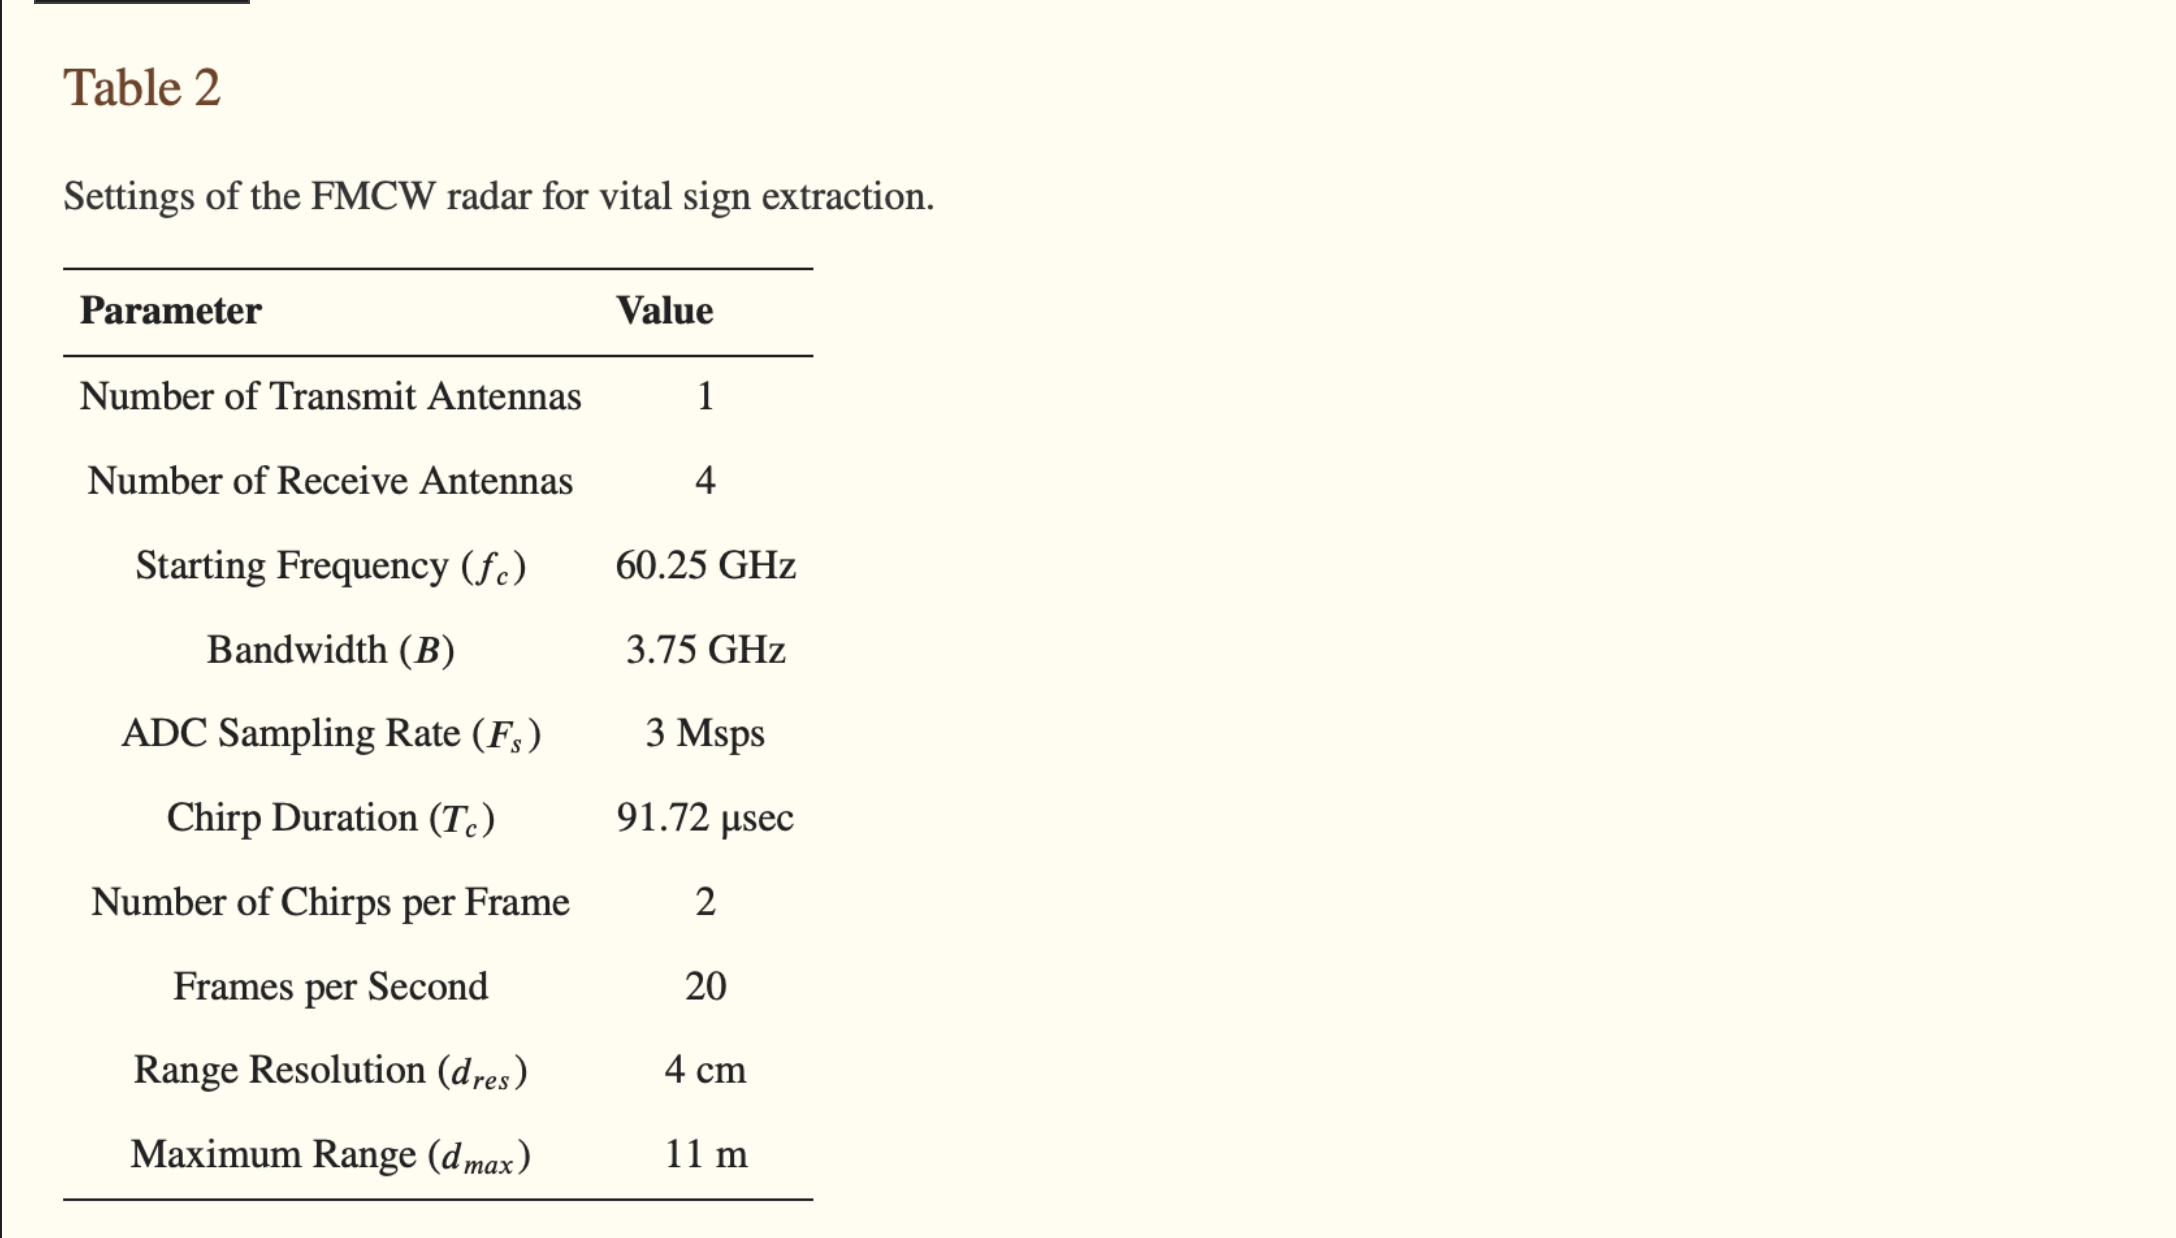

In [23]:
T_c = 91.72 * (1e-6)   # Chirp time
f_start = 60.25*(1e9)  # Hz
NUM_SAMPLE_CHIRP = 256
SAMPLING_RATE = 3000000
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
RANGE_RESOLUTION=4 # 4cm
MAX_RANGE=1100#11 m = 1100 cm
speed_of_light = 299792458

In [24]:
chirps = [raw_data_channel_0[i:i+NUM_SAMPLE_CHIRP]
          for i in range(0, len(raw_data_channel_0), NUM_SAMPLE_CHIRP)]

first_chirps_of_frame = [chirps[j] for j in range(0, len(chirps), 2)]
print(np.array(first_chirps_of_frame).shape)

(6000, 256)


In [25]:
fft_chirps = [np.fft.fft(first_chirp) for first_chirp in first_chirps_of_frame]
magnitude_spectrums = [np.abs(fft_chirp) for fft_chirp in fft_chirps]

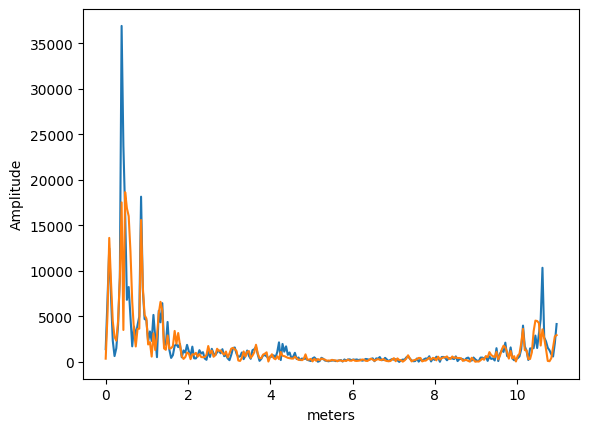

In [33]:
%matplotlib inline
x= np.arange(0,11,11/len(magnitude_spectrums[0]))
plt.plot(x,magnitude_spectrums[0])
plt.plot(x,magnitude_spectrums[2010])
plt.xlabel('meters')
plt.ylabel('Amplitude')
plt.show()

In [34]:

#find it's manitude
magnitude_index = np.zeros(shape=len(magnitude_spectrums))
for  magnitude_spectrum in magnitude_spectrums:
    magnitude = np.abs(magnitude_spectrum)
    max_index=np.argmax(magnitude_spectrum[1:-1])
    magnitude_index[max_index]+=1
bin_of_interest = np.argmax(magnitude_index)
print("bin_of_interest:",bin_of_interest)
for i,val in enumerate(magnitude_index):
    if(0!=val):
        print("index:",i," : ",val)

bin_of_interest: 8
index: 1  :  20.0
index: 6  :  42.0
index: 7  :  199.0
index: 8  :  2805.0
index: 9  :  923.0
index: 10  :  663.0
index: 11  :  121.0
index: 12  :  27.0
index: 13  :  8.0
index: 19  :  1191.0
index: 31  :  1.0


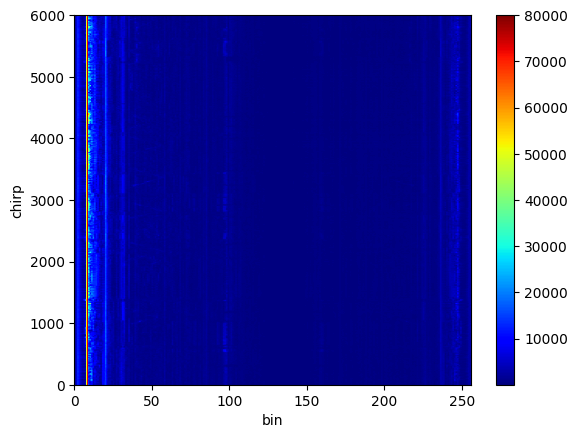

In [35]:
tmp_array= copy.deepcopy(magnitude_spectrums)
for tmp in tmp_array:
    tmp[bin_of_interest]=80000
plt.imshow(tmp_array, cmap='jet', aspect='auto',extent=[0,len(tmp_array[0]),0,len(tmp_array)])
plt.xlabel('bin')
plt.ylabel('chirp')
plt.colorbar()
plt.show()


bin selected:  8
ffts_interested_bin shape:  (6000,)


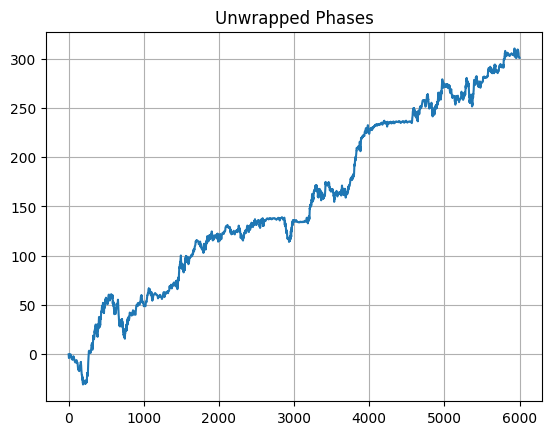

In [36]:
print("bin selected: ",bin_of_interest)
ffts_interested_bin = [fft_chirp[bin_of_interest] for fft_chirp in fft_chirps]
print("ffts_interested_bin shape: ",np.array(ffts_interested_bin).shape)
angles = np.angle(np.array(ffts_interested_bin).flatten())
unwrapped_phase = np.unwrap(angles)
plt.plot(unwrapped_phase)
# plt.plot(frequency_domain_signal)
plt.title('Unwrapped Phases')
plt.grid(True)
plt.show()


bin selected:  1


/Users/truongdinh/Downloads/Children Dataset/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


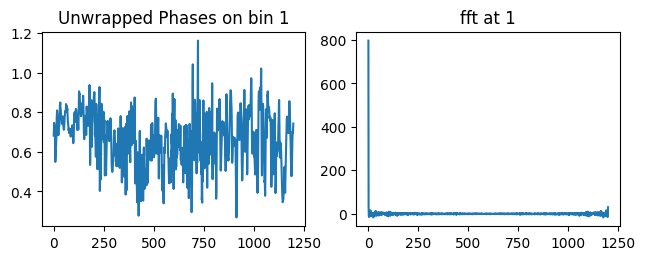

bin selected:  6


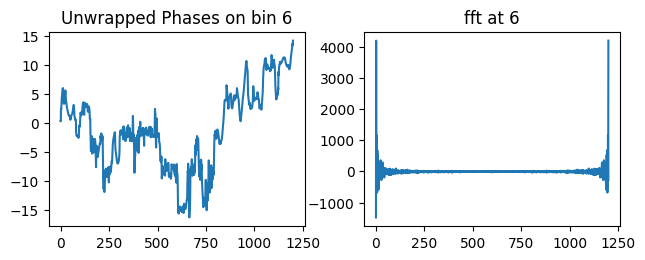

bin selected:  7


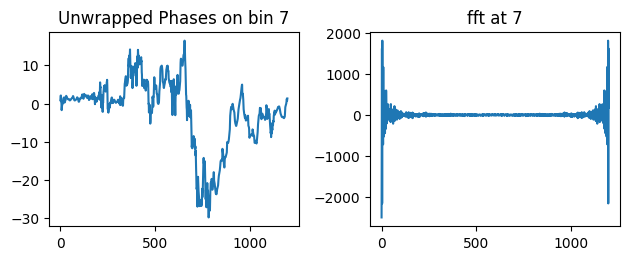

bin selected:  8


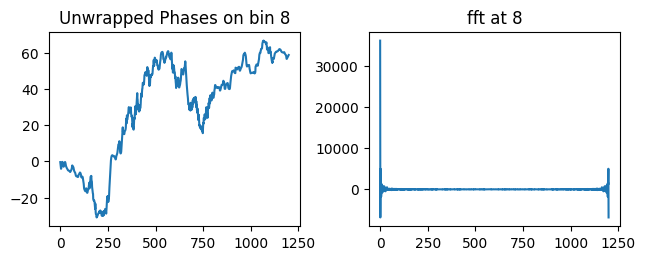

bin selected:  9


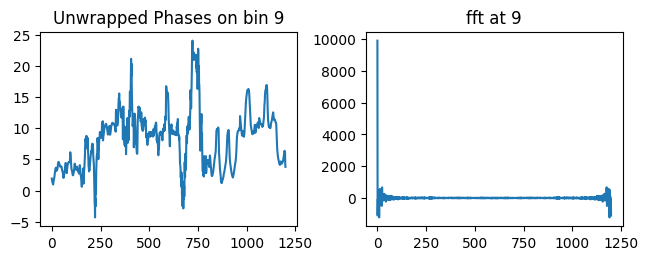

bin selected:  10


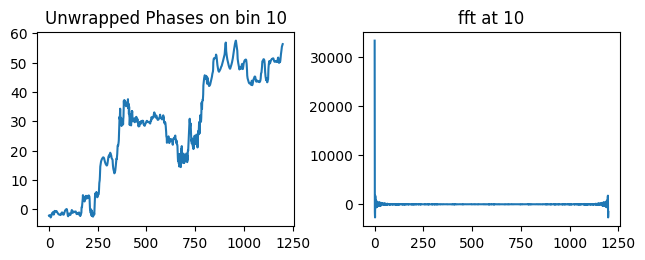

bin selected:  11


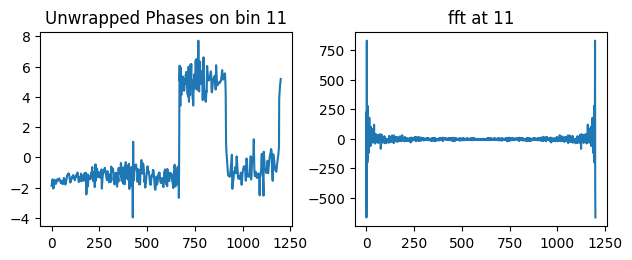

bin selected:  12


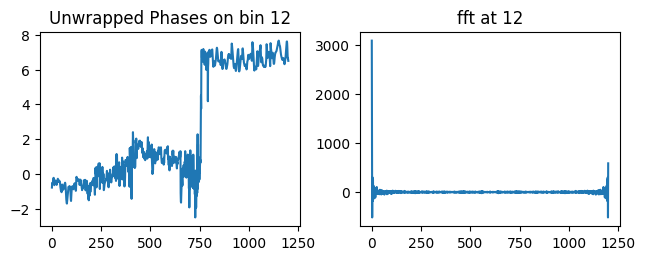

bin selected:  13


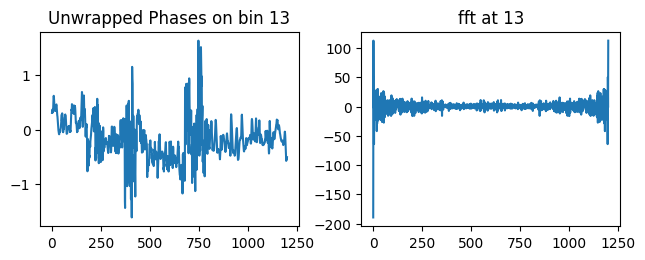

bin selected:  19


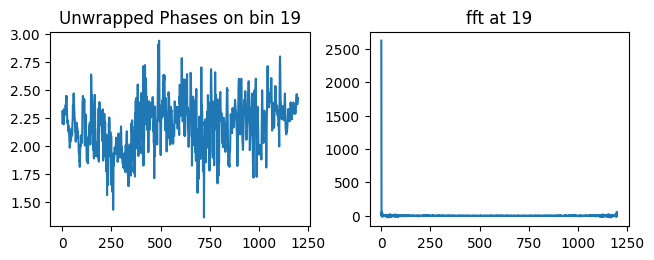

bin selected:  31


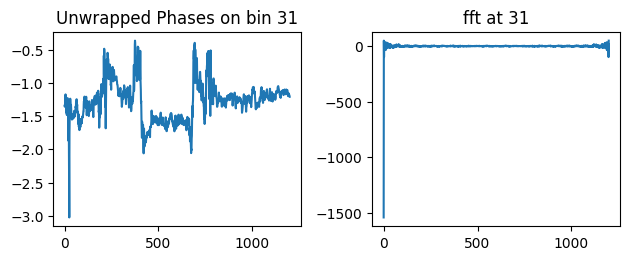

In [45]:
for i,val in enumerate(magnitude_index):
    if(0!=val):
        #20 frame/1s so 60s ->20* 60=1200 sample
        WINDOW_SIZE= 1200
        print("bin selected: ",i)
        ffts_interested_bin = [fft_chirp[i] for fft_chirp in fft_chirps]
        angles = np.angle(np.array(ffts_interested_bin).flatten())
        WINDOW_ANGLE = angles[0:WINDOW_SIZE]
        unwrapped_phase = np.unwrap(WINDOW_ANGLE)
        plt.subplot(2, 2, 1)
        plt.plot(unwrapped_phase)
        plt.title('Unwrapped Phases on bin {0}'.format(i),)

        plt.subplot(2, 2, 2)
        plt.plot(np.fft.fft(unwrapped_phase))
        plt.title('fft at {0}'.format(i),)

        plt.tight_layout()
        plt.show()


        # fs = SAMPLING_RATE/512  #T_c is sweeptime so sampling rate is 1 sample per sweeptime
        # lowcut = 0.4  # Lower cutoff frequency of the bandpass filter
        # highcut = 5  # Upper cutoff frequency of the bandpass filter
        # order = 4  # Filter order

        # # Normalize the cutoff frequencies
        # nyquist_freq = 0.5 * fs
        # low = lowcut / nyquist_freq
        # high = highcut / nyquist_freq

        # # Apply the bandpass filter
        # b, a = butter(order, [low, high], btype='band', fs=fs)
        # filtered_phase_change = filtfilt(b, a, unwrapped_phase)

        # frequency_domain = np.fft.fft(filtered_phase_change)
        # frequencies = np.fft.fftfreq(len(filtered_phase_change), d=1/fs)
   

        # positive_frequencies = frequencies[:len(frequencies)//2]  # Consider only the positive frequencies
        # positive_frequency_domain = frequency_domain[:len(frequencies)//2]  # Corresponding positive frequency domain signal

        # peaks, _ = find_peaks(np.abs(positive_frequency_domain))

        # # Get the peak frequencies in the positive frequency range
        # peak_frequencies = positive_frequencies[peaks]

        # peak_bpm = peak_frequencies * 60

        # print(np.array(filtered_phase_change).shape)
        # plt.figure(figsize=(12, 6))
        # plt.plot(filtered_phase_change)
        
        # plt.xlabel('Frequency (Hz)')
        # plt.ylabel('Amplitude')
        # plt.title('Frequency Domain Signal with Peaks')
        # plt.grid(True)

        plt.show()

    


(6000,)


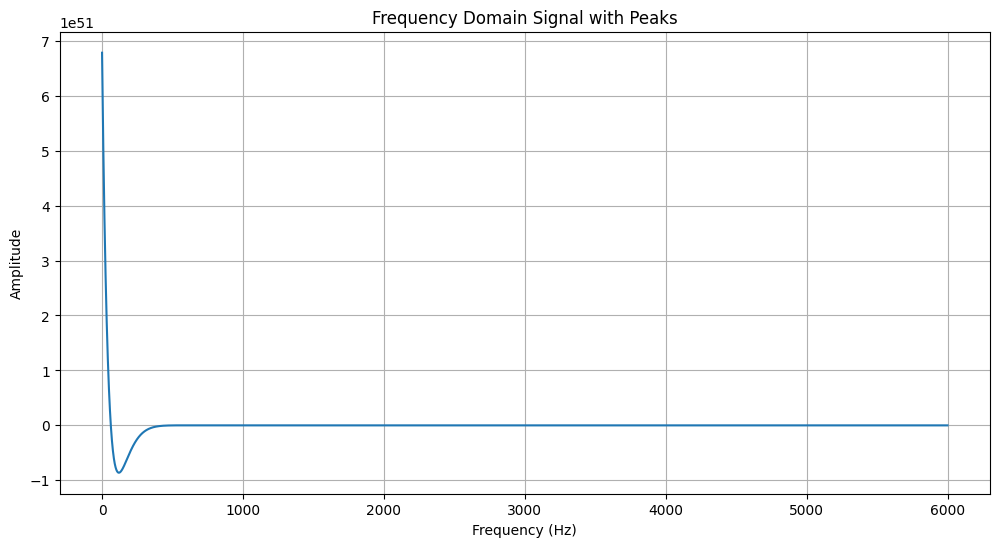

In [38]:
fs = SAMPLING_RATE/512  #T_c is sweeptime so sampling rate is 1 sample per sweeptime
lowcut = 0.4  # Lower cutoff frequency of the bandpass filter
highcut = 5  # Upper cutoff frequency of the bandpass filter
order = 4  # Filter order

# Normalize the cutoff frequencies
nyquist_freq = 0.5 * fs
low = lowcut / nyquist_freq
high = highcut / nyquist_freq

# Apply the bandpass filter
b, a = butter(order, [low, high], btype='band', fs=fs)
filtered_phase_change = filtfilt(b, a, unwrapped_phase)

frequency_domain = np.fft.fft(filtered_phase_change)
frequencies = np.fft.fftfreq(len(filtered_phase_change), d=1/fs)
# peaks, _ = find_peaks(np.abs(frequency_domain))
# # Get the peak frequencies
# peak_frequencies = frequencies[peaks]

positive_frequencies = frequencies[:len(frequencies)//2]  # Consider only the positive frequencies
positive_frequency_domain = frequency_domain[:len(frequencies)//2]  # Corresponding positive frequency domain signal

peaks, _ = find_peaks(np.abs(positive_frequency_domain))

# Get the peak frequencies in the positive frequency range
peak_frequencies = positive_frequencies[peaks]

peak_bpm = peak_frequencies * 60

print(np.array(filtered_phase_change).shape)
plt.figure(figsize=(12, 6))
plt.plot(filtered_phase_change)
# plt.plot(frequencies, np.abs(frequency_domain))
# plt.plot(peak_frequencies, np.abs(frequency_domain[peaks]), 'ro')
# for i, freq in enumerate(peak_frequencies):
#     plt.annotate(f'{freq:.2f} Hz', (freq, np.abs(positive_frequency_domain[peaks[i]])),
#                  xytext=(5, 10), textcoords='offset points', color='blue')

# for i, bpm in enumerate(peak_bpm):
#     plt.annotate(f'{bpm:.2f} BPM', (peak_frequencies[i], np.abs(positive_frequency_domain[peaks[i]])),
#                  xytext=(5, 10), textcoords='offset points', color='blue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Domain Signal with Peaks')
plt.grid(True)

plt.show()
